# Stratify Continuous Score by Severity

In [12]:
from pyspark.sql.functions import *

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data

In [2]:
ROOT_PATH="gs://green-1-accelerators-1-username-dpr-stg-bucket/"
FILE_PATH="scoring/Document/Customer"
CUSTOMER_PATH="customer/DocumentDataModel/CleansedDocumentDataModel.parquet"
SCORE_ID_OF_INTEREST="HighRiskCustomerContinuous"

Load the output score and customer data.

In [3]:
df = spark.read.parquet(ROOT_PATH+FILE_PATH)

In [4]:
customers = spark.read.parquet(ROOT_PATH+CUSTOMER_PATH)

Find the score of interest to select a stratification.

In [5]:
score_customers = df.select("id",col("basicScoreOutputMap")\
                 .getItem(SCORE_ID_OF_INTEREST).alias("scoreOutput"))\
                .select("id","scoreOutput.*")

Replace null severities with zero.

In [6]:
score_customers_severities = score_customers\
        .select("id", "severity", "description")\
        .withColumn("severity", when(col("severity").isNull(),lit(0))\
                    .otherwise(col("severity")))

### Group the data into bins

Group the data into bins and plot histogram.

In [7]:
score_customers_severities_pd = score_customers_severities.toPandas()

In [8]:
score_customers_severities_pd.head(10)

,id,severity,description
0,1937937421,0,None
1,5085464662,0,None
2,6029246402,0,None
3,10092942152,25,High risk customer Harry Krichauff (10092942152).
4,10910136667,100,High risk customer Matthew Tremper (10910136667).
5,14790341630,0,None
6,24986141054,0,None
7,28471596220,0,None
8,34113997963,0,None
9,35067368037,0,None


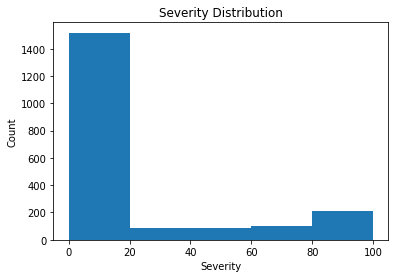

In [9]:
n, bins, patches = plt.hist(score_customers_severities_pd.severity,bins=5)
plt.title("Severity Distribution")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()

In [10]:
bins

array([  0.,  20.,  40.,  60.,  80., 100.])

In [11]:
n

array([1517.,   84.,   85.,  101.,  213.])

### Sample data

Choose fractions of each severity to sample. To do this create a dictionary where the keys are the lower bound of the bins of the histogram and the values are the fractional value of the number of samples you want for each key. <br>
We take a small percentage of customers in the lowest bin because we have the most customers in this group and these are the customers with a low severity and therefore unlikely to be of much interest to the client.

In [13]:
severity_counts_pd = pd.DataFrame({"severity":bins[0:len(bins)-1], "total_count":n})

In [14]:
def create_fractions_for_sample(severity_counts_df, sample_sizes):
    """
    function to create custom dictionary of fractions for severity samples.
    severity_counts_df: pandas dataframe containing severities and total counts
    sample_sizes: ordered list of the required sample size for each severity. 
    (The sampling is probabilistic and therefore the required sample sizes are 
    an approximation of the number of samples you will receive. It is therefore 
    advised to use 2 as the minimum sample size to ensure that a sample is obtained.)
    """
    severity_counts_df['sample_count'] = sample_sizes
    fractions_dict = {}
    for index, row in severity_counts_df.iterrows():
        fractions_dict[int(row[0])] = row[2]/row[1]
        
    return fractions_dict

In [15]:
fractions = create_fractions_for_sample(severity_counts_pd, [2,2,3,3,4])

In [16]:
score_customers_severities_bins = score_customers_severities.\
    withColumn("severityBins", when(col("severity")<20,0).otherwise(
    when(col("severity")<40,20).otherwise(
    when(col("severity")<60,40).otherwise(
    when(col("severity")<80,60).otherwise(80    
    )))))

In [17]:
sampled_df = score_customers_severities_bins.stat\
             .sampleBy("severityBins", fractions, seed=123)

In [18]:
score_customers_severities_count=score_customers_severities.groupBy("severity").count()\
    .select(col("severity"), col("count").alias("total_count"))

In [20]:
sampled_df_count=sampled_df.groupBy("severityBins").count()\
    .select(col("severityBins").alias("severity"), col("count").alias("sample_count"))

In [21]:
score_customers_severities_count.join(sampled_df_count,"severity").orderBy("severity").show()

+--------+-----------+------------+
|severity|total_count|sample_count|
+--------+-----------+------------+
|       0|       1517|           1|
|      20|          4|           1|
|      40|          2|           3|
|      60|          3|           2|
|      80|          3|           6|
+--------+-----------+------------+



### Join sampled data with customers

Read in the customer data and join to the sampled data. Select the key features to show to client.

In [22]:
sampled_df_customers = sampled_df\
            .join(customers, sampled_df.id == customers.customerIdNumberString)

In [23]:
sampled_df_output = sampled_df_customers\
    .select("customerIdNumber", "forename", "familyName", "severity", "description")

In [24]:
sampled_df_output.limit(20).toPandas().head(20)

,customerIdNumber,forename,familyName,severity,description
0,44062026113,Lukas,Schultz,71,High risk customer Lukas Schultz (44062026113).
1,69831468694,Steven,Olesen,70,High risk customer Steven Oleary (69831468694).
2,77640044198,Malcolm,Alston,43,High risk customer Malcolm Alston (77640044198).
3,59136631098,Desire,Deslauriers,54,High risk customer Desire Deslaurie (591366310...
4,99798232913,M,Williams,100,High risk customer Mamie Williams (99798232913).
5,58891927697,None,None,0,None
6,78420972928,Stefan,Kohl,50,High risk customer Stefan Kohl (78420972928).
7,75440916009,Charles,Flores,100,High risk customer Charles Flores (75440916009).
8,27352445533,Armentar,Soria,85,High risk customer Armentar Soria (27352445533).
9,2174571809,Dylan,Foster,100,High risk customer Dylan Foster (2174571809).


Save output

In [25]:
sampled_df_output.repartition(1).write.csv(path=ROOT_PATH+SCORE_ID_OF_INTEREST+"_samples.csv", mode="overwrite", header="true")

In [ ]:
#if running locally
#sampled_df_output_pd = sampled_df_output.toPandas()
#sampled_pd.to_csv(ROOT_PATH+"sample_file.csv", header=True, index=False)
#sampled_pd.to_excel(ROOT_PATH+"sample_file.xlsx", header=True, index=False)